# Demo Notebook

This notebook demonstrates how to use the `gdar` package for neural data analysis.

## Creating a structural connectivity graph

The `gdar` package provides functions for creating a structural connectivity graph that the model operates on. Graphs can be created from user defined edge lists, or a dictionary of node positions and graph generator functions provided in the package.

### Creating graph from edge list

Let's first start by creating a graph from a user defined edge list.

In [1]:
from gdar.graph import Graph

edge_list = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)]
graph = Graph()
graph.generate_from_edge_list(edge_list)

We can visualize the graph using the the `plot_graph` function in the visualization module. To plot the graph. we also need to define the node positions.

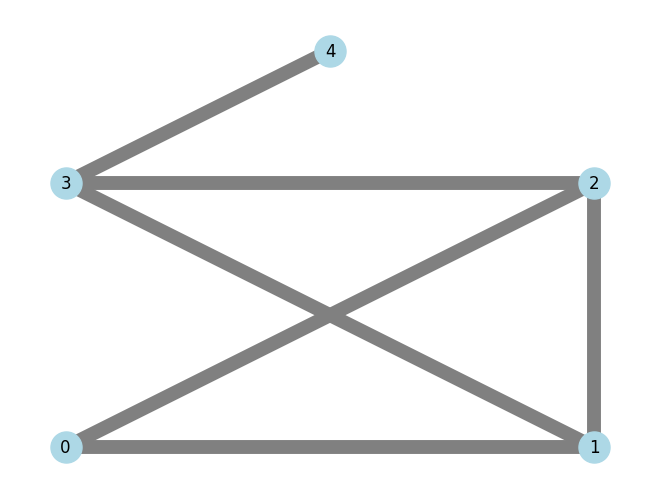

In [8]:
from gdar.visualization import *
from matplotlib import pyplot as plt

node_positions = {
    0: (0, 0, 1),
    1: (1, 0, 1),
    2: (1, 1, 1),
    3: (0, 1, 0),
    4: (0.5, 1.5, 0)
}
graph.set_node_position_name(node_positions)
plot_graph(
    graph,
    projection='xy',
    directed=False, # whether the graph is directed or undirected
    node_size=500, # size of the nodes
    node_color='lightblue', # color of the nodes
    edge_color='gray', # color of the edges
    width=10, # withs of the edges
    with_labels=True # whether to show the node labels
)
plt.show()

Sometimes it is useful to manually add edges to the graph. This can be done using the `add_edges` method.

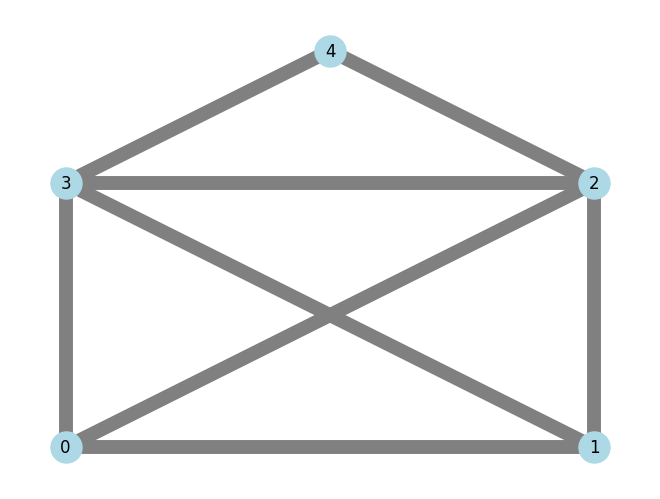

In [3]:
edges_to_add = [(0, 3), (2, 4)]
graph.add_edges(edges_to_add)

# We can visualize the graph again to see the added edges
plot_graph(
    graph,
    directed=False,
    node_size=500,
    node_color='lightblue',
    edge_color='gray',
    width=10,
    with_labels=True
)
plt.show()

### Creating graph from graph generator

Let's assume we have a larger recording array or are interested in the interactions between many brain regions. In this case, we can use the graph generator functions provided in the package to create a graph. An example array is provided in the demo_files directory. The file contains a dictionary of node IDs and their corresponding positions in a 2D space. The `Graph` class provides some simple generator methods to create nearest neighbor and proximity based graphs. 

Node position dictionary {0: array([3.  , 2.25]), 1: array([3.  , 0.75]), 2: array([2.25, 1.5 ]), 3: array([1.5 , 0.75]), 4: array([1.5 , 3.75]), 5: array([1.5 , 2.25]), 6: array([0.75, 3.  ]), 7: array([0.75, 1.5 ]), 8: array([0.75, 6.  ]), 9: array([0.75, 4.5 ]), 10: array([1.5 , 6.75]), 11: array([1.5 , 5.25]), 12: array([2.25, 4.5 ]), 13: array([2.25, 3.  ]), 14: array([2.25, 6.  ]), 15: array([3.  , 3.75]), 16: array([3.  , 5.25]), 17: array([3.  , 6.75]), 18: array([3.75, 6.  ]), 19: array([4.5 , 6.75]), 20: array([4.5 , 5.25]), 21: array([5.25, 6.  ]), 22: array([6.  , 3.75]), 23: array([5.25, 4.5 ]), 24: array([5.25, 1.5 ]), 25: array([5.25, 3.  ]), 26: array([4.5 , 2.25]), 27: array([4.5 , 3.75]), 28: array([4.5 , 0.75]), 29: array([3.75, 4.5 ]), 30: array([3.75, 3.  ]), 31: array([3.75, 1.5 ])}


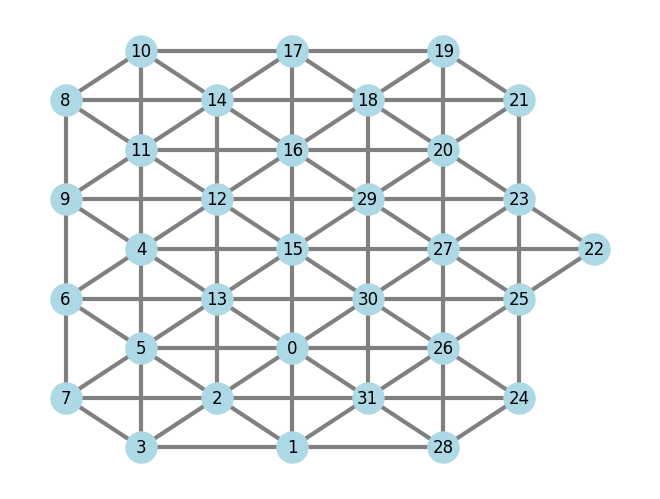

In [4]:
import pickle

# load node positions
with open('demo_files/node_positions.pkl', 'rb') as f:
    node_positions = pickle.load(f)
print(f'Node position dictionary {node_positions}')

# create a graph from the node positions using proximity based graph generator
graph2 = Graph()
graph2.proximity_graph(node_positions, dist_th=2)

# visualize the graph
plot_graph(
    graph2,
    directed=False,
    node_size=500,
    node_color='lightblue',
    edge_color='gray',
    width=3,
    with_labels=True
)
plt.show()

# Fitting the GDAR model

Now that we have a graph, we can fit the GDAR model to neural data. We will first generate some toy data to demonstrate the fitting process. The `gdar` package provides a `GDARModel` class that can be used to fit the model to the data using teh `fit_gdar` function. To fit the GDAR model we need the previously defined graph object as well as the model order, which is the number of previous time points used for predicting the next time point.

The output of the `fit_gdar` function is a matrix of coefficients that has the shape `(N, N, K)`, where `N` is the number of nodes in the graph and `K` is the model order. Each slice `coefficients[:, :, k]` contains the coefficients for the k-th time point. Furthermore, `coefficients[i, j, :]` contains the coefficients for the {i, j} edge. If the edge does not exist in the graph, the coefficients will be zero.

In [5]:
import numpy as np

# generate toy data
np.random.seed(42)  # for reproducibility
T = 1000  # number of time points
N = len(node_positions)  # number of nodes
# generate random data for each node
data = np.random.randn(N, T)

# create a GDAR model instance
from gdar.gdar_model import GDARModel
model_order = 5
gdar_model = GDARModel(graph=graph2, K=model_order)

# fit the model to the data
coefficients = gdar_model.fit_gdar(data)
print(f'Fitted coefficients shape: {coefficients.shape}')

Fitted coefficients shape: (32, 32, 5)


## Computing and visualizing the GDAR flow

The GDAR flow can be computed using the `get_flow_gdar` function. The output of the function is a `FlowSignal` object that contains the flow signal as well as the underlying graph. Differnt snapshots of the flow signal can be visualized using the `plot_flow_graph` function.

Flow matrix shape: (97, 996)


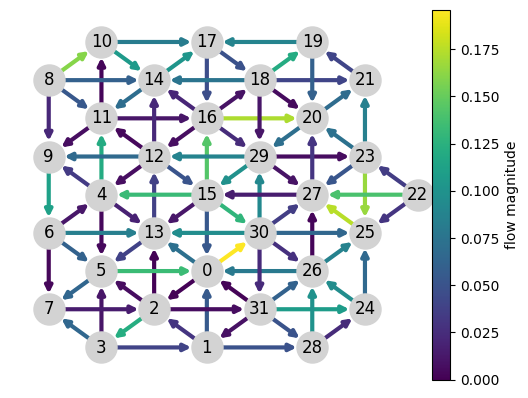

In [6]:
from matplotlib import cm
flow_signal = gdar_model.get_flow_gdar(data, coefficients)

# flow matrix
print(f'Flow matrix shape: {flow_signal.f.shape}')

# visualize one flow snapshot
cmap = cm.viridis # colormap for the flow signal
plot_flow_graph(
    flow_signal.graph,
    flow_signal.f[:, 100], # flow signal at time point 100
    edge_vmin=0,
    directed=True,
    edge_cmap=cmap,
    node_size=500,
    width=3,
    with_labels=True
)
plt.show()

## (Graph)-Spectral Decomposition of Flow Signal

Using the Hodge transform, the flow signal can be decomposed into its gradient, curl and harmonic component which can be further decomposed into its eigenmodes. The `FlowSignal` object provides various functions for computing the Hodge decomposition and the spectrum of the flow signal.

In [7]:
# To compute the curl (rotational) component, we first need to define the edge to triangle incident matrix, which can be done for example using the
# delaunay_triangulation function in the graph module.

B2 = flow_signal.graph.delaunay_triangulation(graph2.node_positions)
print(f'Edge to triangle incident matrix shape: {B2.shape}')

# now we can compute the full Hodge decomposition for the given graph
w_grad, V_grad, w_curl, V_curl, w_harmonic, V_harmonic = flow_signal.hodge_decomposition(mode='full')

Edge to triangle incident matrix shape: (97, 47)


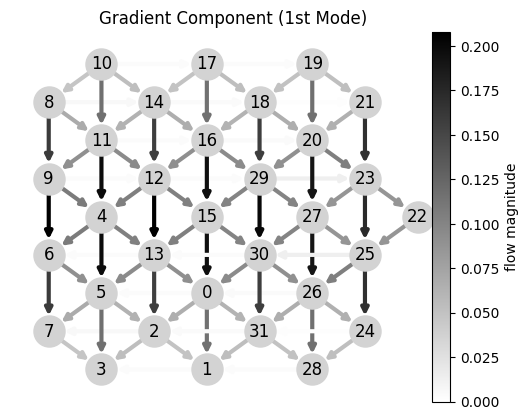

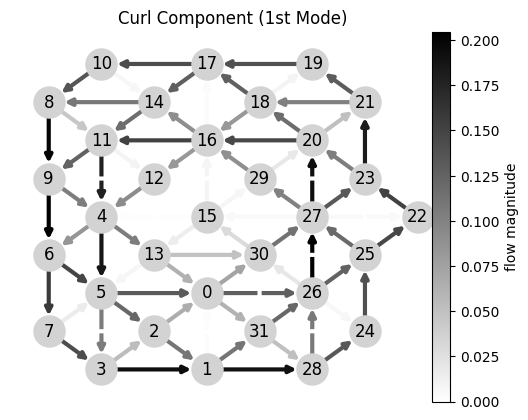

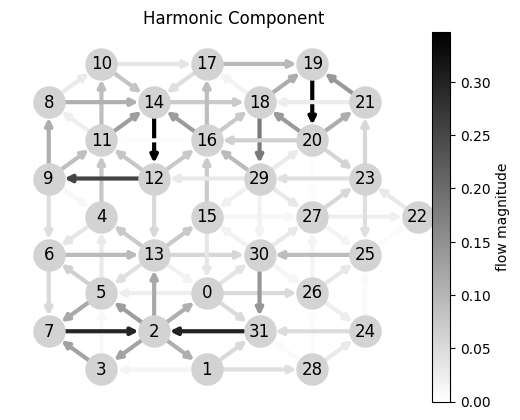

In [8]:
# we can visualize the components using the plot_flow_graph function
cmap = cm.binary
# visualize a low frequency gradient component
plot_flow_graph(
    flow_signal.graph,
    V_grad[:, 0],  # first gradient mode
    edge_vmin=0,
    directed=True,
    edge_cmap=cmap,
    node_size=500,
    width=3,
    with_labels=True
)
plt.title('Gradient Component (1st Mode)')
plt.show()

# visualize a low frequency curl component
plot_flow_graph(
    flow_signal.graph,
    V_curl[:, 0],  # first curl mode
    edge_vmin=0,
    directed=True,
    edge_cmap=cmap,
    node_size=500,
    width=3,
    with_labels=True
)
plt.title('Curl Component (1st Mode)')
plt.show()

# visualize a harmonic component (the harmonic components don't have a natural ordering, since they correspond to zero eigenvalues of the Hodge Laplacian)
plot_flow_graph(
    flow_signal.graph,
    V_harmonic[:, 0],  # first harmonic mode
    edge_vmin=0,
    directed=True,
    edge_cmap=cmap,
    node_size=500,
    width=3,
    with_labels=True
)
plt.title('Harmonic Component')
plt.show()

Now we can compute the flow spectra and visualize them. We will obtain a spectrum for each time point in the flow signal.

Gradient spectrum shape: (31, 996)


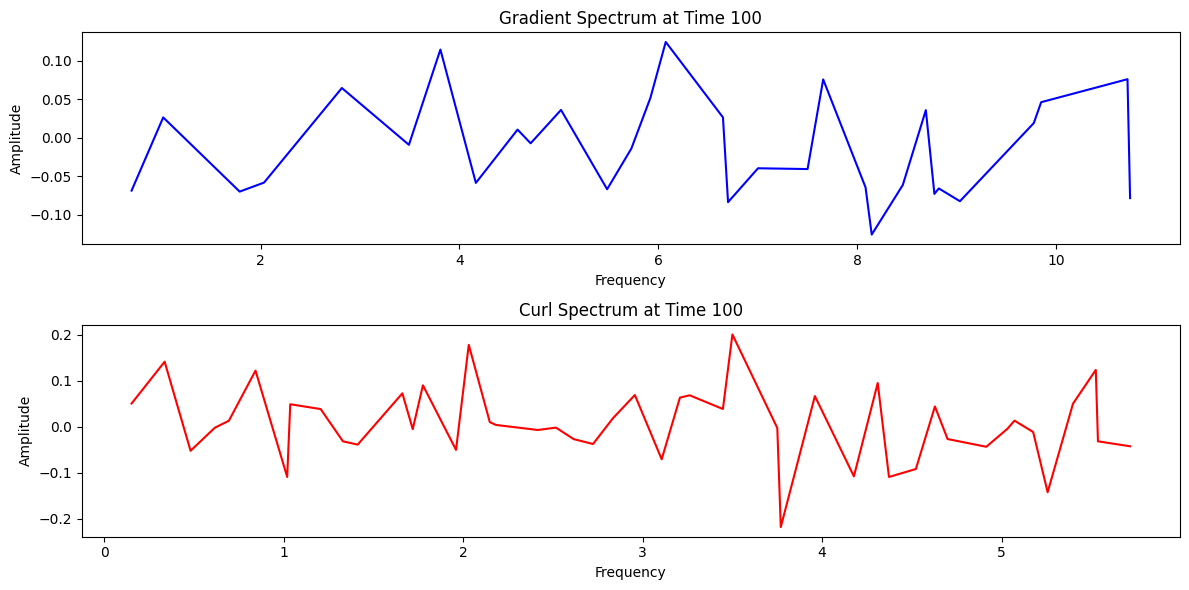

In [9]:
# compute the flow spectra
w_grad, F_grad, w_curl, F_curl, w_harmonic, F_harmonic = flow_signal.flow_ft(mode='full')
print(f'Gradient spectrum shape: {F_grad.shape}')

# visualize the gradient and curl spectrum at time 100 in a single plot
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(w_grad, F_grad[:, 100], label='Gradient Spectrum', color='blue')
ax[0].set_title('Gradient Spectrum at Time 100')
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Amplitude')
ax[1].plot(w_curl, F_curl[:, 100], label='Curl Spectrum', color='red')
ax[1].set_title('Curl Spectrum at Time 100')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Amplitude')
plt.tight_layout()
plt.show()

We can also compute spectrogram or "Power spectral density" estimates by taking the magnitude square of the flow spectra and average over multiple time points. This can be done using the `spectrogram` function in the `FlowSignal` class.

Spectrogram gradient shape: (31, 100)


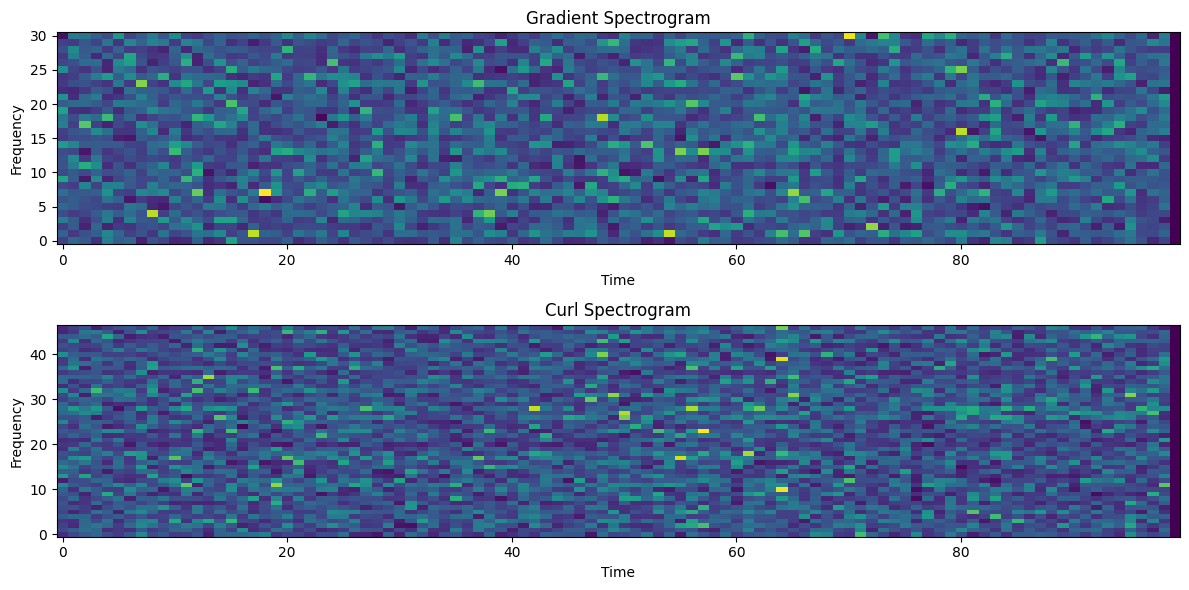

In [13]:
# compute the spectrogram for the gradient and curl components
w_grad, Spec_grad, w_curl, Spec_curl = flow_signal.spectrogram(avg_win = 10, mode='full')
print(f'Spectrogram gradient shape: {Spec_grad.shape}')

# visualize the spectrogram for the gradient and curl components
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].imshow(Spec_grad, aspect='auto', origin='lower', cmap='viridis')
ax[0].set_title('Gradient Spectrogram')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Frequency')
ax[1].imshow(Spec_curl, aspect='auto', origin='lower', cmap='viridis')
ax[1].set_title('Curl Spectrogram')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()